In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

// ## Turn on equation numbering ##

<IPython.core.display.Javascript object>

In [83]:
# import the required libraries

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import datasets as ds

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the Boston Housing dataset, which is part of the sklearn datasets
boston = ds.load_boston()

In [3]:
print("Typ des importierten Objektes: " + str(type(boston)) + "\n")

print("Ein Bunch ist eine besondere Art von Python Dictionary.  \nDie Schlüsselwerte des boston Datensatzes sind: " + str(boston.keys()) + "\n")

print("Die Kurzbeschreibung des Datensatzes: " + str(boston.DESCR))

Typ des importierten Objektes: <class 'sklearn.utils.Bunch'>

Ein Bunch ist eine besondere Art von Python Dictionary.  
Die Schlüsselwerte des boston Datensatzes sind: dict_keys(['data', 'target', 'feature_names', 'DESCR'])

Die Kurzbeschreibung des Datensatzes: Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units bui

In [4]:
Xarray = boston.data

Y = boston.target

X = pd.DataFrame(Xarray, columns = boston.feature_names)



Mit den Methoden head, describe, und info, bekommen wir einen besseren Überblick über unseren Datensatz, und wie er aufgebaut ist.

In [5]:
print(X.head())
print(X.describe())
print(X.info())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  
0     15.3  396.90   4.98  
1     17.8  396.90   9.14  
2     17.8  392.83   4.03  
3     18.7  394.63   2.94  
4     18.7  396.90   5.33  
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    

Wir haben also 506 Beobachtungen insgesamt. Schauen wir auch schnell, wieviele fehlende Werte im Datensatz sind: in diesem gibt es keine (unrealistisch, aber das sind die meisten Textbuch Beispiele ja auch)

In [6]:
# To figure out the missing values
missing = len(X.index) - X.count()
missing

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

Wie alle braven Data Scientists, teilen wir jetzt, bevor wir weitermachen, unseren Datensatz in Trainingsdaten und Testdaten auf. Ungefähr 100 Testdaten sind ausreichend, also setzen wir test_size auf 20%.

In [7]:
# Now, lets split the data into train and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 18)

Um uns den Einstieg zu erleichtern, wählen wir zuerst eine Variable aus - z.B. INDUS (proportion of non-retail business acres per town) - und suchen hier die Regressionslinie.

In [8]:
oneX_train = X_train.INDUS.values.reshape(-1,1)
oneX_test = X_test.INDUS.values.reshape(-1,1)

Auf jeden Fall, sollten wir auch die Daten Visualisieren, bevor wir weitermachen:

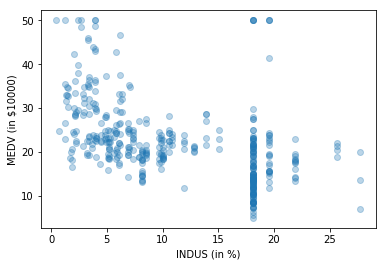

In [9]:
plt.scatter(x = oneX_train, y = Y_train, alpha = 0.3)
plt.xlabel("INDUS (in %)")
plt.ylabel("MEDV (in $10000)")
plt.show()

Es schaut nicht ganz wie eine gerade Linie aus, aber einen Trend könnte man schon erkennen. Bevor wir aber mit der Regression fortfahren, sollten wir uns das Graph genau anschauen, denn es hat ein paar Besonderheiten.  Erstens sticht uns die vertikale Linie um 18% INDUS ins Auge.  Was bedeutet das?  Schnell einen Blick ins Histogramm, und die Erklärung ist da: 

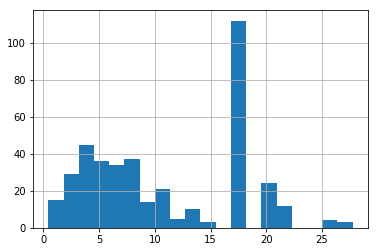

In [10]:
X_train.INDUS.hist(bins=20, figsize=(6, 4))
plt.show()

Es gibt so viele Beobachtungen mit INDUS = 18%, daß sie sich gleichmäßig auf alle MEDV Werte bis 30 verteilt haben.

Wir bemerken aber auch die zwei Punkte bei 18% und 20% INDUS, und 50 MEDV.  Das sind **Outlier**: *der $Y$ Wert dieser Punkte weicht stark vom $Y$-Wert anderer Punkte mit dem gleichen $X$-Wert ab*.  Sind es einzelne Fälle, oder befinden sich mehrere Beobachtungen auf den gleichen Punkten? Wir waren vorausschauend, und haben bei der Zeichnung unseres Scatterplots *alpha* auf einen niedrigen Wert gesetzt.  Somit sind vereinzelte Punkte eher blass, und mehrfach besetzte Punkte fest.  Also deutet alles darauf hin, daß mehrere Beobachtungen auf dem Punkt (INDUS = 18, MEDV = 50) bzw. (INDUS = 20, MEDV = 50) sitzen.  Ist diese Gruppe an abweichenden Beobachtungen doch nur eine Laune dieses Datensatzes ("Noise"), oder verbirgt sich eine Geschichte dahinter?  Wir können das hier nicht weiterverfolgen, halten aber fest, daß solche starken Abweichungen leider unsere Loss-function in die Mitleidenschaft ziehen werden. 

Zum Schluß noch eine Anmerkung: ganz oben bei MEDV = 50, sieht man die Punkte sich fast in eine horizontale Linie ziehen.  Könnte es sein, daß dieser Datensatz bei 50 gecappt wurde?  Wer sich die Scatterplots von den restlichen Variablen vs. MEDV anschaut, wird gleich merken, daß dem wirklich so ist.  Und in so einem Fall, kann es manchmal nützlich sein, die grenzwertigen Beobachtungen zu eliminieren, denn sie fälschen die Daten nur ab. 

In [73]:
# That's it!  We can run the linear regression now!
lin_reg = LinearRegression()  # instantiate a linear regression object
lin_reg_model = lin_reg.fit(oneX_train, Y_train) # this requires reshaping our data, it won't take simply oneX_train = X_train.INDUS
Y_predictions = lin_reg.predict(oneX_train)


In [74]:
# Check the results:
lin_mse = mean_squared_error(Y_train, Y_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(Y_train, Y_predictions)

medY = np.median(Y_train, axis = 0)
maxY = np.max(Y_train, axis = 0)

print("Die Lineare Regression mit zwei Variabeln hat eine training RMSE von " + str(lin_rmse) + ",")
print("und eine training MAE von " + str(lin_mae) + "erreicht.")
print("Vergleichen Sie das mit einem Y Medianwert von " + str(medY) + " und einem Y Maximalwert von " + str(maxY) +  ".")



Die Lineare Regression mit zwei Variabeln hat eine training RMSE von 7.9799737477,
und eine training MAE von 5.74545930615erreicht.
Vergleichen Sie das mit einem Y Medianwert von 21.2 und einem Y Maximalwert von 50.0.


In [76]:
cv_scores = cross_val_score(lin_reg, oneX_train, Y_train, scoring = "neg_mean_squared_error", cv = 10)
cv_rmse_scores = np.sqrt(-cv_scores)

print("RMSE Scores: ", cv_rmse_scores)
print("RMSE Mean: ", cv_rmse_scores.mean())
print("RMSE Standard Deviation: ", cv_rmse_scores.std())

RMSE Scores:  [  6.04850579   8.36983866   7.09131188  10.91971711   8.39723303
  10.91589092   6.58577874   4.95211717   8.91157528   5.719442  ]
RMSE Mean:  7.79114105889
RMSE Standard Deviation:  1.97081433811


In [77]:
cv_mae_scores = -cross_val_score(lin_reg, oneX_train, Y_train, scoring = "neg_mean_absolute_error", cv = 10)

print("MAE Scores: ", cv_mae_scores)
print("MAE Mean: ", cv_mae_scores.mean())
print("MAE Standard Deviation: ", cv_mae_scores.std())

MAE Scores:  [ 5.21651681  5.25870341  5.98409085  7.99216218  5.80349091  7.00498772
  5.19502115  3.9958816   6.4367551   4.88877665]
MAE Mean:  5.77763863804
MAE Standard Deviation:  1.08519832546


Das schaut nicht sehr gut aus - und ist noch dazu der RMSE Wert auf den Trainingsdaten!  Wie sieht es denn mit den Testdaten aus?

Die Lineare Regression mit zwei Variabeln hat eine test RMSE von 8.28314750575,
und eine test MAE von 5.82184039957erreicht.
Vergleichen Sie das mit einem Y Medianwert von 21.2 und einem Y Maximalwert von 50.0.
Das Bestimmtheitsmaß beträgt 0.231139641127.


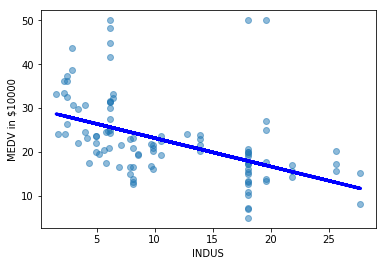

In [78]:
Y_predictions = lin_reg.predict(oneX_test)

# Check the results:
lin_mse = mean_squared_error(Y_test, Y_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_mae = mean_absolute_error(Y_test, Y_predictions)
r2 = r2_score(Y_test, Y_predictions)

print("Die Lineare Regression mit zwei Variabeln hat eine test RMSE von " + str(lin_rmse) + ",")
print("und eine test MAE von " + str(lin_mae) + "erreicht.")
print("Vergleichen Sie das mit einem Y Medianwert von " + str(medY) + " und einem Y Maximalwert von " + str(maxY) +  ".")

print("Das Bestimmtheitsmaß beträgt " + str(r2) + ".")


plt.scatter(x = oneX_test, y = Y_test, alpha = 0.5)
plt.xlabel("INDUS")
plt.ylabel("MEDV in $10000")
plt.plot(oneX_test, Y_predictions, color='blue', linewidth=3)
plt.show()

In [51]:
lin_params = {"Steigung": lin_reg.coef_[0], "Achsenabschnitt": lin_reg.intercept_}
print("Und so schaut jetzt unsere Gerade aus: y = %.2fx + %.2f" %(lin_params["Steigung"], lin_params["Achsenabschnitt"]))

Und so schaut jetzt unsere Gerade aus: y = -0.65x + 29.65


Die **MAE** hat hier den Vorteil, daß sie große Abweichungen nicht so stark bestraft wie die **RMSE**.  Dies ist in unserem Falle vielleicht auch gerechtfertigt, denn die Gerade ist, mit Ausnahme der zwei Outlier, nicht so schlecht wie es der große RMSE vermuten läßt.

Ein letztes Beurteilungskriterium möchten wir noch erproben: mittels Residual Plot sind oft andere Regressionsprobleme zu entdecken.

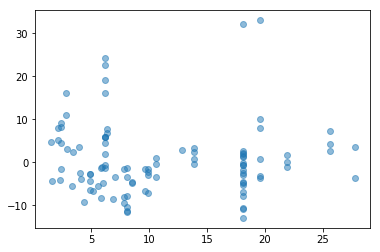

In [52]:
# Look at the residual plots: (for one variable, it is res vs x, for multivar it is res vs pred y)
res = Y_test - Y_predictions
plt.scatter(x = oneX_test, y = res, alpha = 0.5)
plt.show()


Wer mehr Statistiken will, z.B. p-Werte für die Koeffizienten, oder die F_Statistik, sollte lieber zu statsmodels.api greifen.


Eine Lineare Gleichung gibt es auch mit mehreren unabhängigen Variabeln $X_1, X_2, ..., X_k$:
$$
Y = m_1X_1 + m_2X_2 + \cdots + m_kX_k + n
$$

Und auch hier findet man, aber mit etwas mehr Mühe und linearer Algebra dazu, anhand der **MSE**
$$
L = \frac{1}{t} \sum_{(x,y) \in D} (y - \hat y)² 
  = \frac{1}{t} \sum_{(x,y) \in D} (y - m_1x_1 - m_2x_2 - \cdots -m_kx_k -n)²
$$
die optimalen parameter $m_i$ und $n$.


Schauen wir uns jetzt die ganze multivariable Konstellation an.

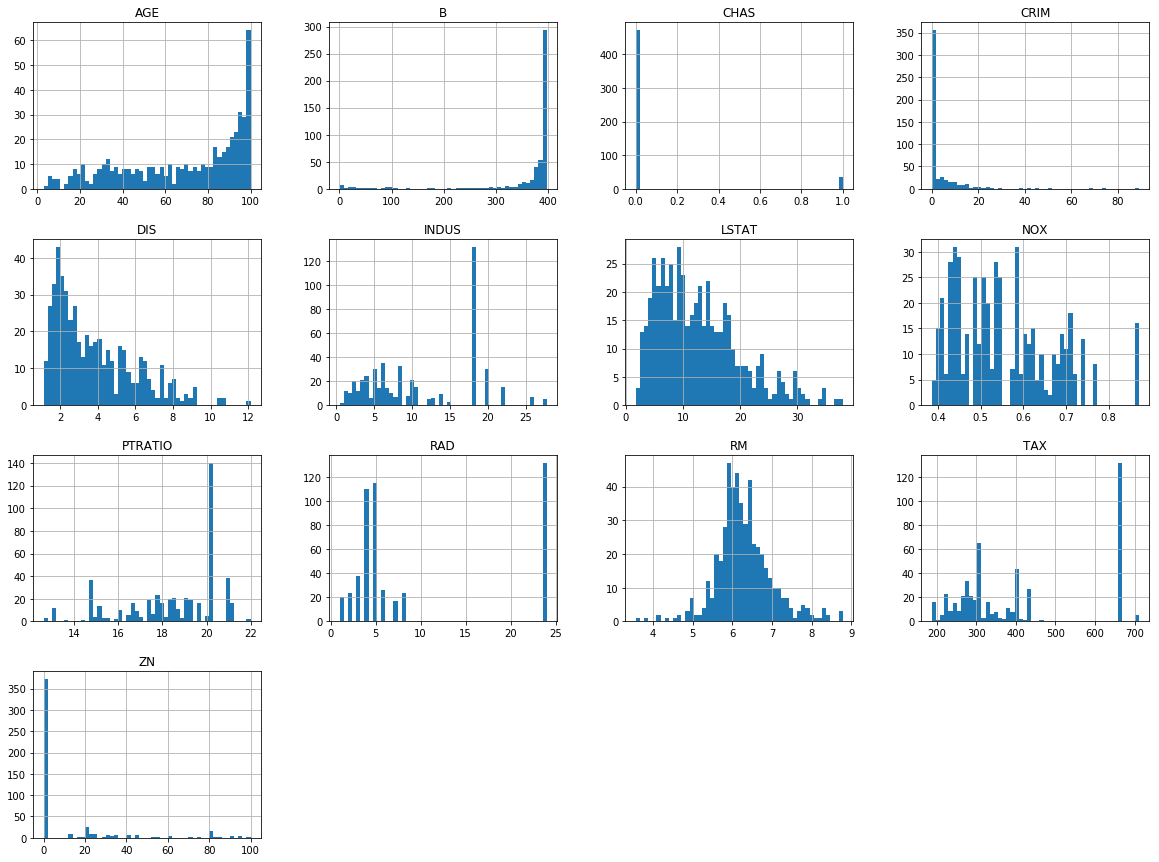

In [30]:
# graph the data to take a look

# only in a Jupyter Notebook
%matplotlib inline 


X.hist(bins = 50, figsize = (20, 15))
plt.show()

Wer gut aufgepasst hat, wird merken, daß die Variable CHAS nur zwei Werte hat: 0 und 1.  Das ist, weil CHAS eigentlich eine Indikatorvariable ist: es ist gleich eins, wenn die Immobilie direkt am Charles River liegt, und ist sonst null.

In [57]:
# That's it!  We can run the linear regression now!
lin_reg_mult = LinearRegression()
lin_reg_multmodel = lin_reg_mult.fit(X_train, Y_train)


Y_mult_predictions = lin_reg_multmodel.predict(X_test)

In [79]:
cv_mae_mult_scores = -cross_val_score(lin_reg, X_train, Y_train, scoring = "neg_mean_absolute_error", cv = 10)

print("MAE Scores: ", cv_mae_mult_scores)
print("MAE Mean: ", cv_mae_mult_scores.mean())
print("MAE Standard Deviation: ", cv_mae_mult_scores.std())

MAE Scores:  [ 3.20098442  3.61924282  3.54944016  3.92840005  3.92694319  4.23864812
  2.31802656  2.81274499  3.57540293  3.10416752]
MAE Mean:  3.42740007701
MAE Standard Deviation:  0.547405129008


In [90]:
from scipy.stats import ttest_ind
# if instead, we want a paired t-test, we would use ttest_rel

# Student's t-test
# H0: There is no difference between the MAE scores of simple vs. multiple linear regression on the boston housing data set
# H1: There is a difference between MAE scores

alpha = 0.05
data1 = cv_mae_scores 
data2 = cv_mae_mult_scores
stat, p = ttest_ind(data1, data2)

print("Der p-Wert ist: ", p)
if (p < alpha):
    print("Wir lehnen die Null-Hypothese ab, and akzeptieren die Alternative:")
    print("Es gibt ausreichende Indizien für einen Leistungsunterschied zwischen der simplen, und der multilinearen Regression.")
else:
    print("Es bestehen ungenügend Beweise, um die Null-Hypothese abzulehnen:")
    print("Es gibt unzureichende Indizien für einen Leistungsunterschied zwischen der simplen, und der multilinearen Regression.")


Der p-Wert ist:  1.69858020888e-05
Wir lehnen die Null-Hypothese ab, and akzeptieren die Alternative:
Es gibt ausreichende Indizien für einen Leistungsunterschied zwischen der simplen, und der multilinearen Regression.


In [89]:
from scipy.stats import ttest_rel

stat_pair, p_pair = ttest_rel(data1, data2)
print(stat_pair)
print(p_pair)

8.96975355646
8.77637399088e-06


In [86]:
# Check the results:
lin_mult_mse = mean_squared_error(Y_test, Y_mult_predictions)
lin_mult_rmse = np.sqrt(lin_mult_mse)
lin_mult_mae = mean_absolute_error(Y_test, Y_mult_predictions)
r2_mult = r2_score(Y_test, Y_mult_predictions)

print("Die Multivariable Lineare Regression hat eine test RMSE von " + str(lin_mult_rmse) + ",")
print("und eine test MAE von " + str(lin_mult_mae) + "erreicht.")
print("Das Bestimmtheitsmaß beträgt " + str(r2_mult) + ".")

print("Vergleichen Sie das mit den Werten der simplen Linearen Regression:")
print("test RMSE: " + str(lin_rmse))
print("test MAE: " + str(lin_mae))
print("Bestimmtheitsmaß: " + str(r2))



Die Multivariable Lineare Regression hat eine test RMSE von 5.25740041785,
und eine test MAE von 3.62814662624erreicht.
Das Bestimmtheitsmaß beträgt 0.69025893305.
Vergleichen Sie das mit den Werten der simplen Linearen Regression:
test RMSE: 8.28314750575
test MAE: 5.82184039957
Bestimmtheitsmaß: 0.231139641127


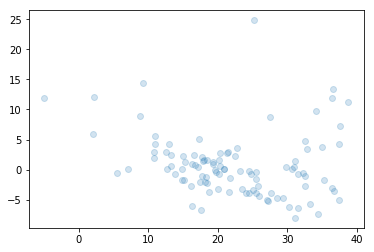

In [37]:
# Look at the residual plots: (for one variable, it is res vs x, for multivar it is res vs pred y)
res = Y_test - Y_predictions
plt.scatter(x = Y_predictions, y = res, alpha = 0.2)
plt.show()

Plot of X = CRIM versus Y = MEDV


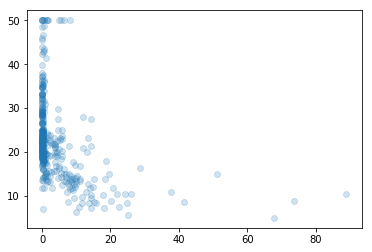

--------------------------------------------
Plot of X = ZN versus Y = MEDV


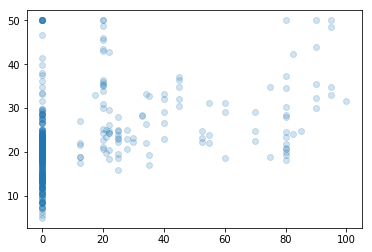

--------------------------------------------
Plot of X = INDUS versus Y = MEDV


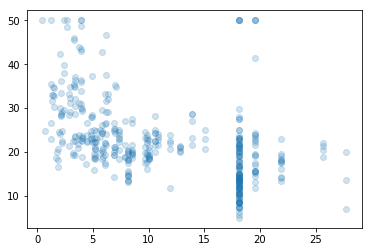

--------------------------------------------
Plot of X = CHAS versus Y = MEDV


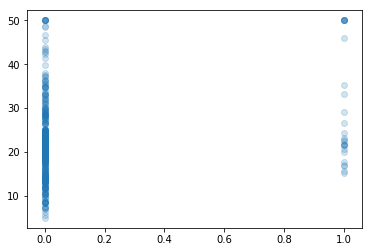

--------------------------------------------
Plot of X = NOX versus Y = MEDV


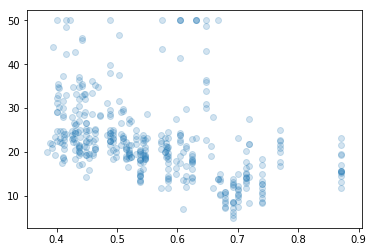

--------------------------------------------
Plot of X = RM versus Y = MEDV


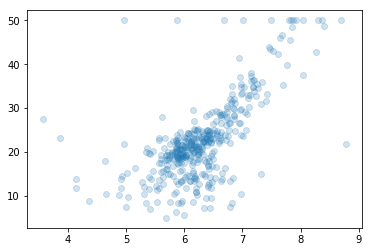

--------------------------------------------
Plot of X = AGE versus Y = MEDV


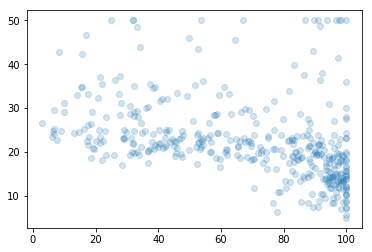

--------------------------------------------
Plot of X = DIS versus Y = MEDV


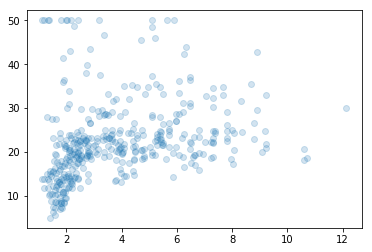

--------------------------------------------
Plot of X = RAD versus Y = MEDV


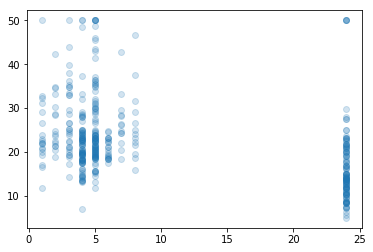

--------------------------------------------
Plot of X = TAX versus Y = MEDV


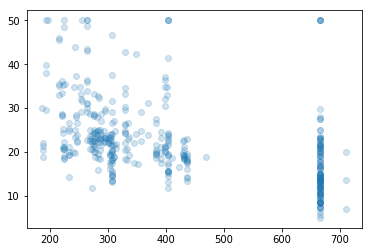

--------------------------------------------
Plot of X = PTRATIO versus Y = MEDV


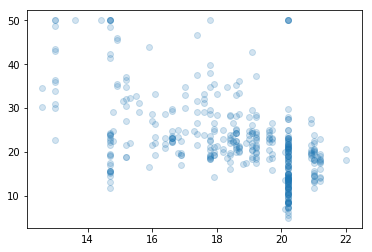

--------------------------------------------
Plot of X = B versus Y = MEDV


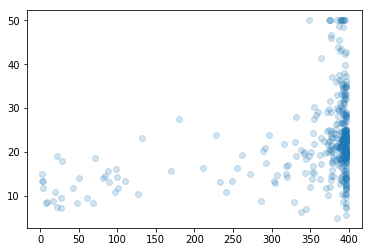

--------------------------------------------
Plot of X = LSTAT versus Y = MEDV


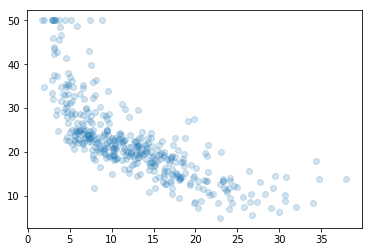

--------------------------------------------


In [16]:
for col in X_train.columns:
    print("Plot of X = " + col + " versus Y = MEDV")
    plt.scatter(x = X_train[col], y = Y_train, alpha = 0.2)
    plt.show()
    print("--------------------------------------------")